Author: Karlos Lao

GDAA2010 Project 1: 
A Comprehensive Regression Analysis on Beach Turbidity Observations

Last Revision Date: Apr 2, 2024



**1. Problem Definition**

The purpose of this notebook is to investigate the potential of specific metrics in forecasting water turbidity at several renowned public beaches in Toronto.

**2.1 Data Collection and Preprocessing**

Target Variable: Turbidity (numerical).


Predictor Variables:
- Wind speed (numerical)
- Air temperature (numerical)
- Water temperature (numerical)
- Number of waterfowl (numerical)
- Wind Direction (categorical)
- Visual clarity (categorical)

Data Source
The dataset is sourced from the City of Toronto Open Data Portal: [Toronto Beaches Observations](https://open.toronto.ca/dataset/toronto-beaches-observations/)


In [1]:
import requests
import pandas as pd

# Toronto Open Data is hosted on CKAN.
# We can access the data directly through the CKAN API to pull in our dataset
# in a dataframe.

base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"
url = base_url + "/api/3/action/package_show"
params = {"id": "toronto-beaches-observations"}
package_metadata = requests.get(url, params=params).json()

# Go through the resources under the same package, retrieve the data as a list
# One package can have many "resources", iterate each resource, and get the 
# values into a column in a dataframe.

data = []

for resource in package_metadata["result"]["resources"]:
    # Check if the datastore is active for the resource
    if resource["datastore_active"]:
        # Endpoint for searching data in the datastore
        url = base_url + "/api/3/action/datastore_search"
        resource_id = {"id": resource["id"]}
        # Set the limit parameter to fetch all available records
        resource_params = {"limit": 99999999, **resource_id}
        # Fetch data from the datastore
        resource_data = requests.get(url, params=resource_params).json()["result"]

        # Convert the retrieved data into a DataFrame
        dataframe = pd.DataFrame(resource_data["records"])

        # Append the DataFrame to the dataset list
        data.append(dataframe)

# Concatenate all DataFrames in the list to form a single DataFrame
df = pd.concat(data, ignore_index=True)
df.head()

C:\Users\kailo\AppData\Local\Temp\ipykernel_28448\3239301164.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,_id,dataCollectionDate,beachName,windSpeed,windDirection,airTemp,rain,rainAmount,waterTemp,waterFowl,waveAction,waterClarity,turbidity
0,1,2010-08-03,Marie Curtis Park East Beach,5.0,SW,31.0,Yes,NaN,22.6,12.0,LOW,Clear,0.9
1,2,2010-08-03,Sunnyside Beach,5.0,SW,31.0,Yes,NaN,21.9,30.0,LOW,Clear,0.6
2,3,2010-08-03,Hanlan's Point Beach,5.0,SW,31.0,Yes,NaN,24.3,20.0,LOW,Clear,0.1
3,4,2010-08-03,Gibraltar Point Beach,5.0,SW,31.0,Yes,NaN,21.3,12.0,LOW,Clear,NaN
4,5,2010-08-03,Centre Island Beach,5.0,SW,31.0,Yes,NaN,21.3,30.0,LOW,Clear,0.2


In [2]:
# Start data prepping/wrangling

# Renaming variables
df1 = df.rename (columns = {'dataCollectionDate': 'Date',
                           'beachName': 'Beach',
                           'windDirection': 'Wind_Direction',
                           'airTemp': 'Air_Temp',
                           'rain': 'Rain',
                           'rainAmount': 'Precip',
                           'waterTemp': 'Water_Temp',
                           'waterFowl': 'Num_WaterFoul',
                           'windSpeed': 'Wind_Speed',
                           'waveAction': 'Wave_Action',
                           'waterClarity': 'Visual_Clarity',
                           'turbidity': 'Turbidity'}
                )


# Get counts of each beach site
print(df1['Beach'].value_counts())

Beach
Marie Curtis Park East Beach    1687
Sunnyside Beach                 1687
Hanlan's Point Beach            1687
Gibraltar Point Beach           1687
Centre Island Beach             1687
Ward's Island Beach             1687
Cherry Beach                    1687
Woodbine Beaches                1687
Kew Balmy Beach                 1687
Bluffer's Beach Park            1687
Name: count, dtype: int64


*Check & Impute Missing Data*

In [3]:
import numpy as np

df2 = df1.copy()

# There are discrepencies between "rain" and "rain amount", we should remove
# those observations.
# Scenario 1: "Rain" = "Yes" AND "Precip" is None
# Scenario 2: "Rain" = "No" but "Precip" is not 0
df2 = df2[~((df2["Rain"] == 'Yes') & (df2["Precip"].isnull()))]
df2 = df2[~((df2["Rain"] == 'No') & (df2["Precip"] != 0))]

# New Observation: the data entries on precipitation are not consistent 
# and seem to be very problematic, we should not trust this attribute

# Also drop null observations in our essential variables
essential_vars = ['Wind_Speed','Air_Temp', 'Water_Temp',
                   'Num_WaterFoul', 'Turbidity']

df2 = df2.dropna(subset=essential_vars, how='any')

In [4]:
# There are too many classes in this column, we need to refine it.
vc_classes = df2["Visual_Clarity"].unique().tolist()

# Reclassify the classes into three primary groups: clear, murky/cloudy or algae
def categorize(clarity):
    if clarity is pd.NA or pd.isnull(clarity):
        return 'Unknown'
    elif 'clear' in clarity.lower():
        return 'Clear'
    elif 'murky' in clarity.lower() or 'cloudy' in clarity.lower():
        return 'Murky/Cloudy'
    elif 'algae' in clarity.lower():
        return 'Algae'
    else:
        return 'Unknown'

# Apply the funcntion to each record iteratively
df2['Visual_Clarity'] = df2['Visual_Clarity'].apply(categorize)

# Drop those observations with "Unknown"
df2 = df2[~((df2["Visual_Clarity"] == 'Unknown'))]

# Get counts of each category
print(df2['Visual_Clarity'].value_counts())

# The class "Algae" has too few instances, we should drop it
df2 = df2[~((df2["Visual_Clarity"] == 'Algae'))]

Visual_Clarity
Clear           423
Murky/Cloudy    416
Algae             4
Name: count, dtype: int64


In [5]:
# Lastly, inspect the "Date" column to make sure we are getting data
# from a relatively short time range and not winter
from datetime import datetime
import calendar

# Function to extract month from date string
def extract_month(date_str):
    month = datetime.strptime(date_str, '%Y-%m-%d').month
    return calendar.month_name[month]

def extract_year(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d').year


df2["Month"] = df2["Date"].apply(extract_month)
df2["Year"] = df2["Date"].apply(extract_year)

# Limit the time range to summer months (Jun-Sep)
df2 = df2[~(df2["Month"] == 'May')]

# Inspect the number of samples per year
# Samples from 2008 and 2009 are too small, we should drop those
df2 = df2[~((df2["Year"] == 2008) | (df2["Year"] == 2009))]

# Now we can drop the extra columns that we no longer need
df2.drop(columns=['Date', 'Precip','Year', 'Month', 
                  'Beach', 'Wave_Action'], inplace=True
         )

# Check how many observations we have removed from cleaning and prepping
print(f'A total of {abs(df2.shape[0] - df.shape[0])} observations have been removed')
print(f'Our new data frame contains {df2.shape[0]} observations')

A total of 16096 observations have been removed
Our new data frame contains 774 observations


**Check for Value Distribution in the Categorical Variable "Visual_Clarity"**

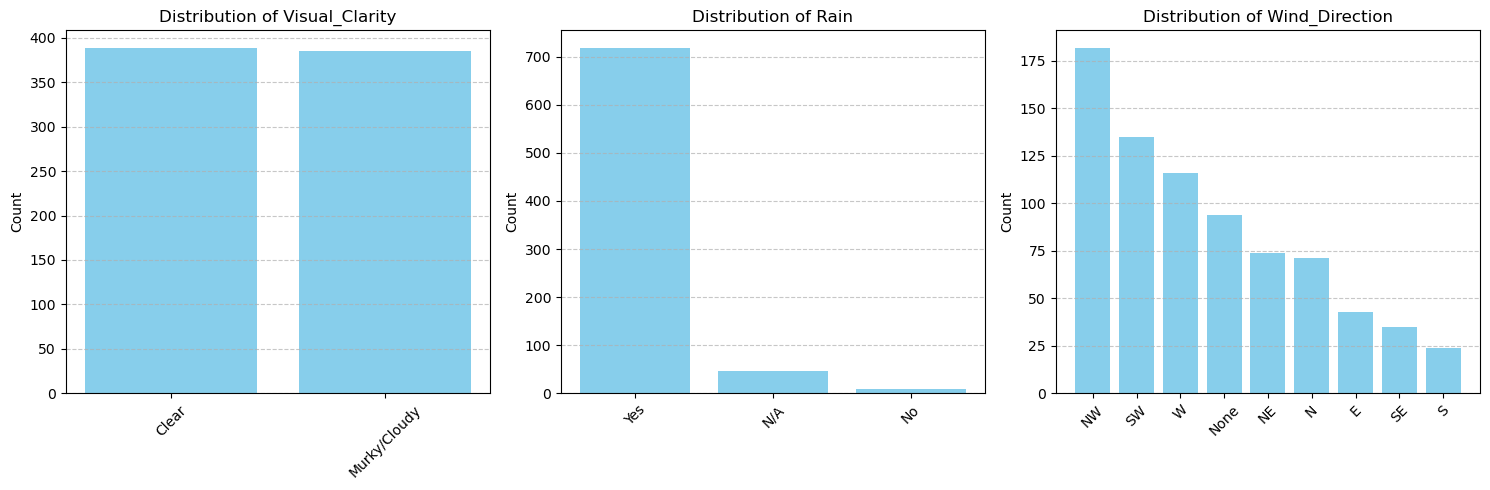

In [6]:
import matplotlib.pyplot as plt
# Separate the categorical variables
cat_vars = ["Visual_Clarity", "Rain", "Wind_Direction"]

# Plot each categorical variable
plt.figure(figsize=(15, 5))
for i, var in enumerate(cat_vars, 1):
    plt.subplot(1, 3, i)
    value_counts = df2[var].value_counts()
    plt.bar(value_counts.index, value_counts.values, color='skyblue')
    plt.title(f'Distribution of {var}')
    plt.xlabel('')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [7]:
# Remove observations where "Rain" is "N/A" or "No"
df2 = df2[df2["Rain"] == 'Yes']

# Remove the column "Rain" since we are only working on a dataset with
# precipitation now
df2.drop(columns=['Rain'], inplace=True)

**Trim for Outliers in Numeric Variables**

array([[<Axes: title={'center': 'Wind_Speed'}>,
        <Axes: title={'center': 'Air_Temp'}>],
       [<Axes: title={'center': 'Water_Temp'}>,
        <Axes: title={'center': 'Num_WaterFoul'}>],
       [<Axes: title={'center': 'Turbidity'}>, <Axes: >]], dtype=object)

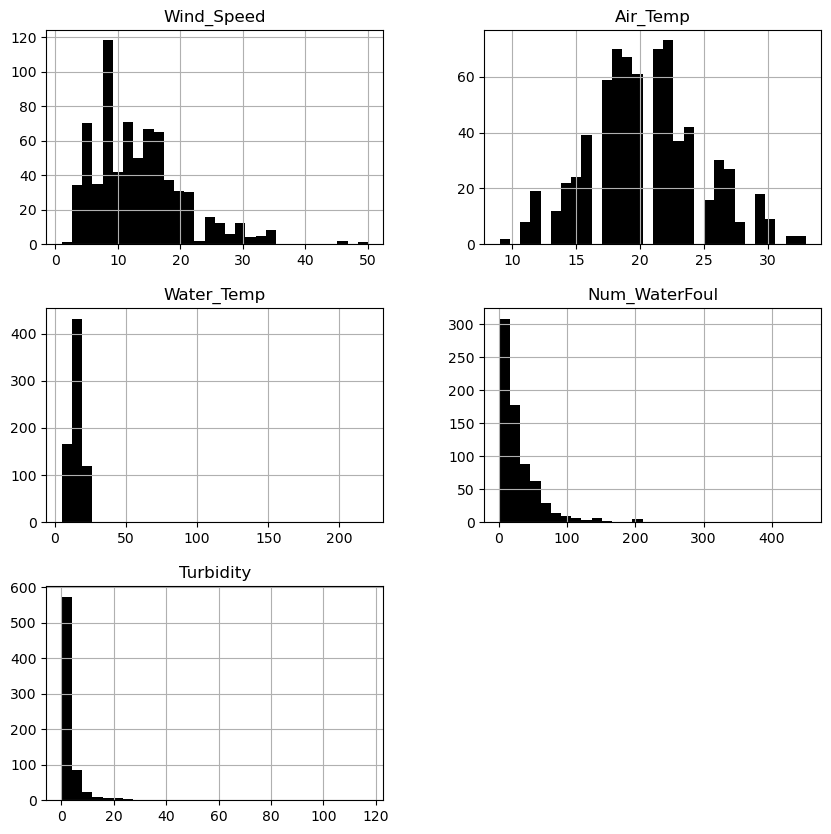

In [8]:
# Separate the numeric variables
numeric_vars = ["Wind_Speed", "Air_Temp","Water_Temp", "Num_WaterFoul", 
                "Turbidity"
                ]

# Inspect the data distribution on the numeric variables
df2[numeric_vars].hist(figsize=(10, 10), bins=30, color='black')

Now the dataframe contains 685 observations


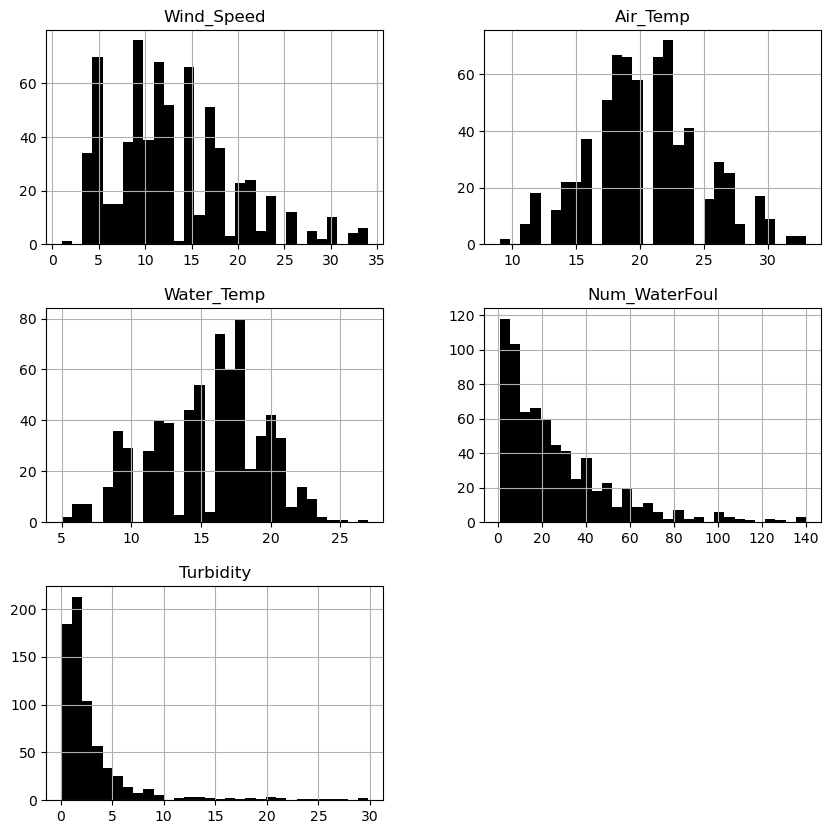

In [9]:
import numpy as np
from scipy import stats

# Start trimming outliers using a threshold of 3 z-scores
z_scores = df2[numeric_vars].apply(stats.zscore)
# Set the threshold for outliers
threshold = 3
# Trim the outliers based by 3 z-scocres
trimmed_df = df2[(np.abs(z_scores) < threshold).all(axis=1)]

# Double Check the results
trimmed_df[numeric_vars].hist(figsize=(10, 10), bins=30, color='black')
print(f'Now the dataframe contains {trimmed_df.shape[0]} observations')

In [10]:
# Rescale the numeric variables after trimming
from sklearn.preprocessing import StandardScaler

# Set the scaler
scaler = StandardScaler()
# Transform the selected variables
rescaled_df = trimmed_df.copy()
rescaled_df[numeric_vars] = scaler.fit_transform(rescaled_df[numeric_vars])

# Also encode the categorical variables using "one-hot encoding"
encoded_df = pd.get_dummies(rescaled_df, columns=['Visual_Clarity', 
                                                 'Wind_Direction'
                                                 ], drop_first=True,dtype=int
                            )

In [11]:
# Drop the '_id' column
encoded_df.drop('_id', axis=1, inplace=True)
print(encoded_df.columns)

Index(['Wind_Speed', 'Air_Temp', 'Water_Temp', 'Num_WaterFoul', 'Turbidity',
       'Visual_Clarity_Murky/Cloudy', 'Wind_Direction_N', 'Wind_Direction_NE',
       'Wind_Direction_NW', 'Wind_Direction_None', 'Wind_Direction_S',
       'Wind_Direction_SE', 'Wind_Direction_SW', 'Wind_Direction_W'],
      dtype='object')


**3. Exploratory Data Analysis**
- Get summary statistics, correlation coefficients, and a scatter plot matrix

In [24]:
eda_df = encoded_df.copy()
# Get summary statistics for both numeric and encoded categorical variables
eda_df.describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
Wind_Speed,685.0,-0.0,1.0,-1.8,-0.8,-0.3,0.6,3.2
Air_Temp,685.0,0.0,1.0,-2.6,-0.5,-0.1,0.6,2.9
Water_Temp,685.0,0.0,1.0,-2.6,-0.6,0.1,0.6,2.9
Num_WaterFoul,685.0,-0.0,1.0,-1.0,-0.7,-0.3,0.5,4.7
Turbidity,685.0,0.0,1.0,-0.7,-0.5,-0.3,0.1,6.8
Visual_Clarity_Murky/Cloudy,685.0,0.5,0.5,0.0,0.0,1.0,1.0,1.0
Wind_Direction_N,685.0,0.1,0.3,0.0,0.0,0.0,0.0,1.0
Wind_Direction_NE,685.0,0.1,0.3,0.0,0.0,0.0,0.0,1.0
Wind_Direction_NW,685.0,0.2,0.4,0.0,0.0,0.0,0.0,1.0
Wind_Direction_None,685.0,0.1,0.3,0.0,0.0,0.0,0.0,1.0


In [25]:
# Air temperature has a moderate positive correlation with water temperature (r=0.45).
# Water temperature has a weak positive correlation with the number of water foul (r=0.09).
# The number of water foul also has a weak positive correlation with air temperature (r=0.21).

eda_df[numeric_vars].corr().round(2)

,Wind_Speed,Air_Temp,Water_Temp,Num_WaterFoul,Turbidity
Wind_Speed,1.00,-0.10,-0.05,-0.03,-0.03
Air_Temp,-0.10,1.00,0.45,0.21,0.07
Water_Temp,-0.05,0.45,1.00,0.09,0.05
Num_WaterFoul,-0.03,0.21,0.09,1.00,0.03
Turbidity,-0.03,0.07,0.05,0.03,1.00


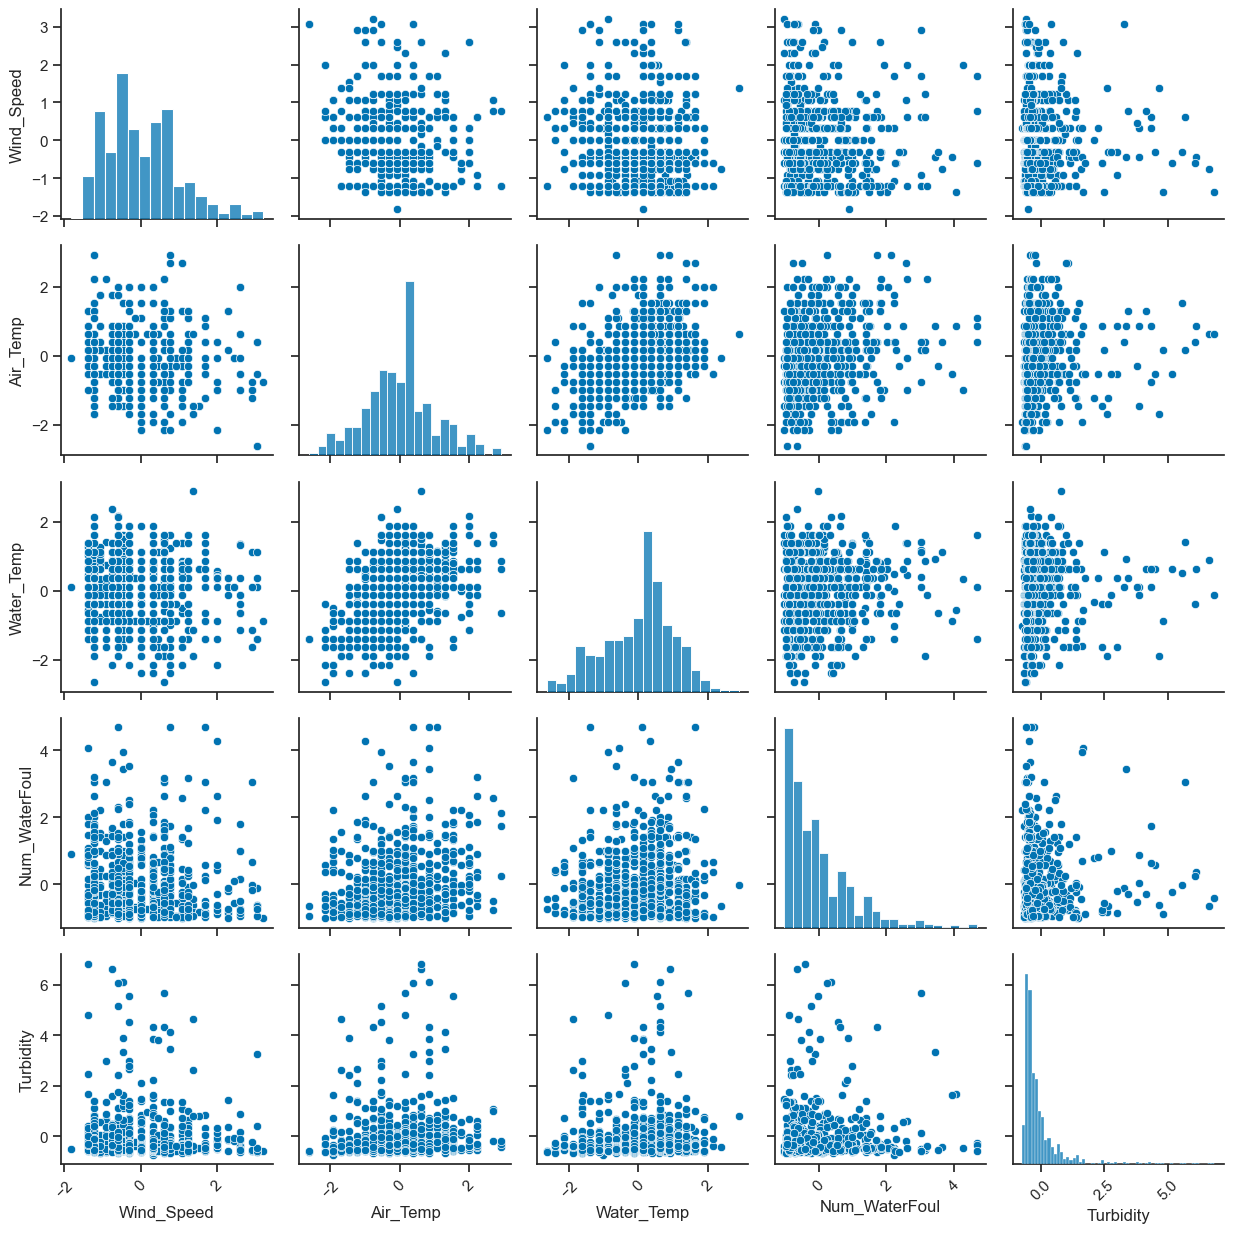

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set_theme(style="ticks", palette="colorblind")

# Create a scatter plot matrix to visualize the relationship between numeric variables
pairplot = sns.pairplot(eda_df, vars=numeric_vars)

# Rotate x-axis labels for better readability
for ax in pairplot.axes.flatten():
    ax.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

**Examine the Two Predictors with the Highest Correlation Coefficients to the Target Variable**

array([[<Axes: title={'center': 'Air_Temp'}>,
        <Axes: title={'center': 'Water_Temp'}>]], dtype=object)

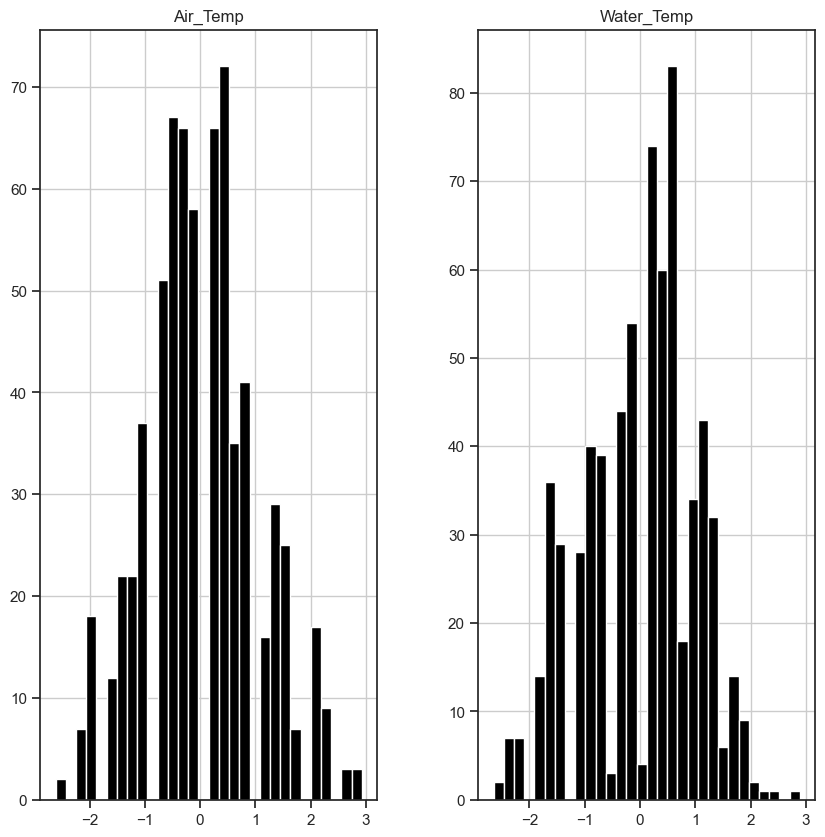

In [27]:
# Air Temp (r=0.07)
# Water Temp (r=0.05)

eda_df[['Air_Temp', 'Water_Temp']].hist(figsize=(10, 10), bins=30, color='black')

# These two variables are not normally distributed, air temperature is slightly
# positively skewed, and precipitationi is very positively skwed. 

**4.1 Feature Engineering: Data Transformation**

c:\Users\kailo\anaconda3\envs\gdaa2000_data_mining\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
c:\Users\kailo\anaconda3\envs\gdaa2000_data_mining\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


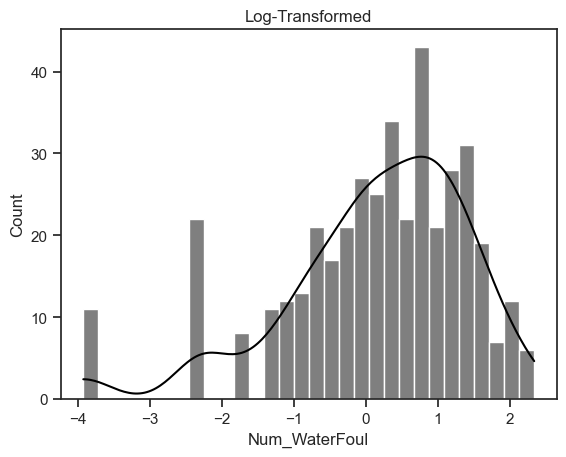

<Figure size 1000x1000 with 0 Axes>

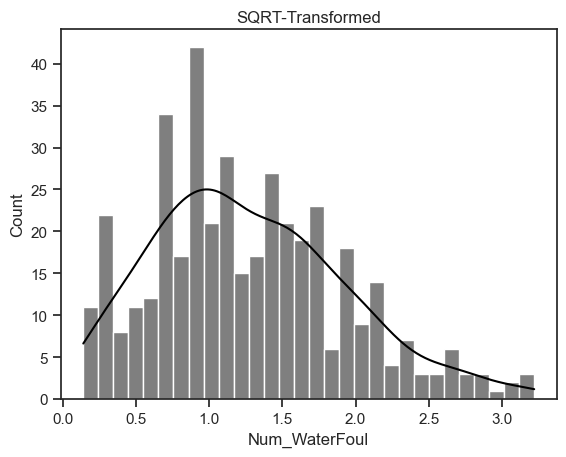

<Figure size 1000x1000 with 0 Axes>

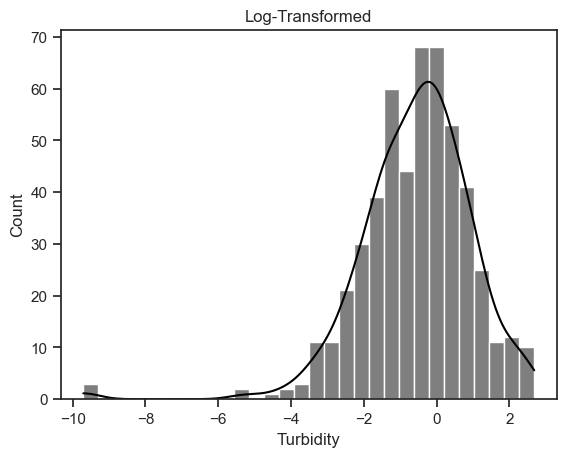

<Figure size 1000x1000 with 0 Axes>

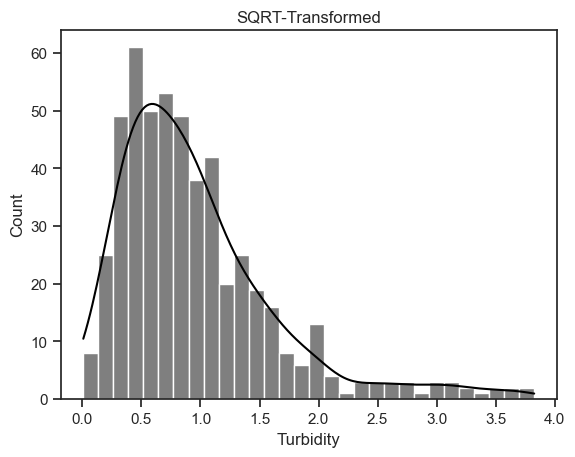

<Figure size 1000x1000 with 0 Axes>

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# The transformation doesn't work on 'Wind_Speed', 'Precip' and "Water_temp",
# due to their data distributions having limited variation and containing 
# numerous gaps in the data values.

# Non-Normal Variables 
pos_skewed_vars= ["Num_WaterFoul", "Turbidity"]

# Specify a scaling factor
scaling_factor = 2

# Try two different transformation method for the positively skewed variables 
# logarithmic transformation
log_trans_df = np.log(eda_df[pos_skewed_vars] * scaling_factor + 1)
# square root transformation
sqrt_trans_df = np.sqrt(eda_df[pos_skewed_vars] * scaling_factor + 1)

sns.histplot(data=log_trans_df["Num_WaterFoul"], bins=30, kde=True, color='black')
plt.title('Log-Transformed')
plt.figure(figsize=(10, 10))
plt.show()

sns.histplot(data=sqrt_trans_df["Num_WaterFoul"], bins=30, kde=True, color='black')
plt.title('SQRT-Transformed')
plt.figure(figsize=(10, 10))
plt.show()

sns.histplot(data=log_trans_df["Turbidity"], bins=30, kde=True, color='black')
plt.title('Log-Transformed')
plt.figure(figsize=(10, 10))
plt.show()

sns.histplot(data=sqrt_trans_df["Turbidity"], bins=30, kde=True, color='black')
plt.title('SQRT-Transformed')
plt.figure(figsize=(10, 10))
plt.show()

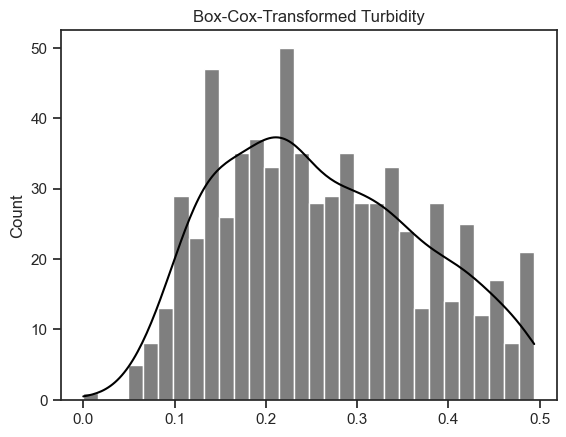

<Figure size 1000x1000 with 0 Axes>

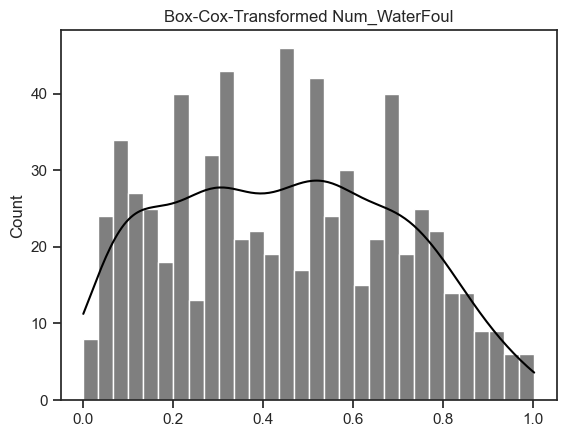

<Figure size 1000x1000 with 0 Axes>

In [40]:
from scipy.stats import boxcox

# Add a constant value make it positive
turb_constant_shift = np.abs(eda_df['Turbidity'].min()) + 1  # Add 1 to avoid zero values
turb_data_shifted = eda_df['Turbidity'] + turb_constant_shift

# Do the same for Num_WaterFoul
wfoul_constant_shift = np.abs(eda_df['Num_WaterFoul'].min()) + 1  # Add 1 to avoid zero values
wfoul_data_shifted = eda_df['Num_WaterFoul'] + wfoul_constant_shift

# Apply Box-Cox transformation
turb_data_boxcox, turb_lambda_boxcox = boxcox(turb_data_shifted)
# Do the same for Num_WaterFoul
wfoul_data_boxcox, wfoul_lambda_boxcox = boxcox(wfoul_data_shifted)

sns.histplot(data=turb_data_boxcox, bins=30, kde=True, color='black')
plt.title('Box-Cox-Transformed Turbidity')
plt.figure(figsize=(10, 10))
plt.show()

sns.histplot(data=wfoul_data_boxcox, bins=30, kde=True, color='black')
plt.title('Box-Cox-Transformed Num_WaterFoul')
plt.figure(figsize=(10, 10))
plt.show()

#print("Lambda (λ) parameter for Box-Cox transformation:", lambda_boxcox)

In [41]:
# Box-cox transformation seems to work best on these two positively 
# skewed variables. Replace the original columns by the transformed values.
eda_df['Turbidity'] = turb_data_boxcox
eda_df['Num_WaterFoul'] = wfoul_data_boxcox

**5. Model/Algorithm Selection**

**6. Model Training**

In [42]:
from sklearn.model_selection import train_test_split

# Create training/validation datasets at a 80/20 split
reg_df = eda_df.copy()

# Predictor variables
x = reg_df.drop(columns=['Turbidity'])

# Target variable
y = reg_df['Turbidity']

# Split the data into training and testing sets (70/30 split)
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                    )

**Polynomial Regression**

In [44]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Create polynomial features
poly_features = PolynomialFeatures(degree=2) # quadratic relationship
x_train_poly = poly_features.fit_transform(x_train)

# Fit polynomial regression model
polynomial_model = LinearRegression().fit(x_train_poly, y_train)


# Calculate mean RMSE with a 10-fold cross-validation
cv_scores = cross_val_score(polynomial_model, 
                            x_train_poly, y_train, cv=10, 
                            scoring='neg_mean_squared_error'
                            )
rmse_scores = np.sqrt(-cv_scores)
poly_mean_rmse = np.mean(rmse_scores)

print(f'RMSE (polynomial regression): {round(poly_mean_rmse,2)}')


RMSE (polynomial regression): 0.1


**Lasso Regression**

In [45]:
from sklearn.linear_model import Lasso

# Initialize the Lasso Regression model
lasso_model = Lasso(alpha=1.0) # regularization strength (adjust if needed)
lasso_model.fit(x_train, y_train)

# Predict on the test set
y_pred = lasso_model.predict(x_test)

# Calculate mean RMSE with a 10-fold cross-validation
cv_scores = cross_val_score(lasso_model, x_train, y_train, cv=10, 
                            scoring='neg_mean_squared_error'
                            )
rmse_scores = np.sqrt(-cv_scores)
lasso_mean_rmse = np.mean(rmse_scores)

print(f'RMSE (lasso regression): {round(lasso_mean_rmse,2)}')

RMSE (lasso regression): 0.11


**Decision Tree Regression**

In [46]:
from sklearn.tree import DecisionTreeRegressor 


# Initializing the Decision Tree model
tree_model = DecisionTreeRegressor().fit(x_train, y_train)
y_pred = tree_model.predict(x_test)

# Calculate mean RMSE with a 10-fold cross-validation
cv_scores = cross_val_score(tree_model, x_train, y_train, cv=10, 
                            scoring='neg_mean_squared_error'
                            )
rmse_scores = np.sqrt(-cv_scores)
tree_mean_rmse = np.mean(rmse_scores)


print(f'RMSE (decision tree regression): {round(tree_mean_rmse,2)}')

RMSE (decision tree regression): 0.13


**Hyperparameter Tuning**

In [47]:
from sklearn.pipeline import make_pipeline

# Look for the optimal number of degree for the polynomial function
np.random.seed(2010)

degrees = range(1, 10)
mean_rmse_scores = []

# Iterate over each degree
for degree in degrees:
    polynomial_model = make_pipeline(PolynomialFeatures(degree), 
                                     LinearRegression()
                                     )
    cv_scores = cross_val_score(polynomial_model, x_train, y_train, cv=10, 
                                scoring='neg_mean_squared_error'
                                )
    rmse_scores = np.sqrt(-cv_scores)
    mean_rmse = np.mean(rmse_scores)
    mean_rmse_scores.append(mean_rmse)

# Find the optimal degree with the lowest mean RMSE
optimal_degree = degrees[np.argmin(mean_rmse_scores)]
optimal_rmse = np.min(mean_rmse_scores)

print("Optimal Degree:", optimal_degree)
print("Lowest Mean RMSE:", optimal_rmse)


Optimal Degree: 1
Lowest Mean RMSE: 0.0974171990801147


In [48]:
# Look for the best alpha parameter for lasso regression

# Define alpha values
alpha_values = np.arange(1, 10001, 10)

rmse_values = []

# Iterate through alpha values
for alpha in alpha_values:
    ridge_model = Lasso(alpha=alpha)
    cv_scores = cross_val_score(ridge_model, x_train, y_train, cv=10, 
                                scoring='neg_mean_squared_error'
                                )
    rmse_scores = np.sqrt(-cv_scores)
    mean_rmse = np.mean(rmse_scores)
    rmse_values.append(mean_rmse)

# Find the index of the minimum RMSE value
min_rmse_index = np.argmin(rmse_values)


print("Lowest overall RMSE value achieved with Lasso regression:", 
      rmse_values[min_rmse_index]
      )

print("Corresponding alpha value:", alpha_values[min_rmse_index])

Lowest overall RMSE value achieved with Lasso regression: 0.10986818711162412
Corresponding alpha value: 1


In [49]:
# Look for the optimal number of max tree depth, min_samples_split, 
# min_samples_leaf, max_features for the decision tree regression

from sklearn.model_selection import GridSearchCV

# Define the grid of parameters to search
param_grid = {
    'max_depth': range(1, 21),
    'min_samples_split': range(2, 21),
    'min_samples_leaf': range(1, 21),
    'max_features': ['auto', 'sqrt', 'log2'] + list(range(1, x.shape[1] + 1))
}

model = DecisionTreeRegressor(random_state=2010)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, 
                           scoring='neg_root_mean_squared_error', n_jobs=-1
                           )

grid_search.fit(x_train, y_train)

# Get the best hyperparameters and RMSE
best_params = grid_search.best_params_
best_rmse = -grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Lowest RMSE:", best_rmse)

c:\Users\kailo\anaconda3\envs\gdaa2000_data_mining\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
76000 fits failed out of a total of 1216000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25529 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kailo\anaconda3\envs\gdaa2000_data_mining\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kailo\anaconda3\envs\gdaa2000_data_mining\Lib\site-packages\sklearn\base.py", line 1344, in wrapper
    estimator._validate_params()
  File "c:\Users\kailo\anaconda3\envs\gdaa2000_data_mining\Lib\site-packages\sklearn\base.py", li

Best Hyperparameters: {'max_depth': 4, 'max_features': 9, 'min_samples_leaf': 11, 'min_samples_split': 2}
Lowest RMSE: 0.09645969873796338


c:\Users\kailo\anaconda3\envs\gdaa2000_data_mining\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ... -0.09817812 -0.09817812
 -0.09817812]
  warnings.warn(


**List of Optimal Hyperparameters for Each Model**

In [50]:
# Optimal degree for the polynomial model
best_degree = optimal_degree
best_rmse_polynomial = round(optimal_rmse,2)

# Best alpha for the lasso regression model
best_alpha = alpha_values[min_rmse_index]
best_rmse_lasso = round(rmse_values[min_rmse_index],2)

# Best hyperparameters for the decision tree model
tree_model_best_params = best_params
best_rmse_tree_model = round(best_rmse,2)

print(f'Optimal degree of polynomial function: {best_degree}\n'
      f'Optimal alpha to use for regularization in the Lasso Regression: '
      f'{best_alpha} \n'
      f'Optimal hyperparameters for the decision tree regression: '
      f'{tree_model_best_params} \n')


Optimal degree of polynomial function: 1
Optimal alpha to use for regularization in the Lasso Regression: 1 
Optimal hyperparameters for the decision tree regression: {'max_depth': 4, 'max_features': 9, 'min_samples_leaf': 11, 'min_samples_split': 2} 



**7.Model Evaluation**

Mean RMSE of the Polynomial Model: 0.1
Mean RMSE of the Lasso Model: 0.11 
Mean RMSE of the Decision Tree Model: 0.1 



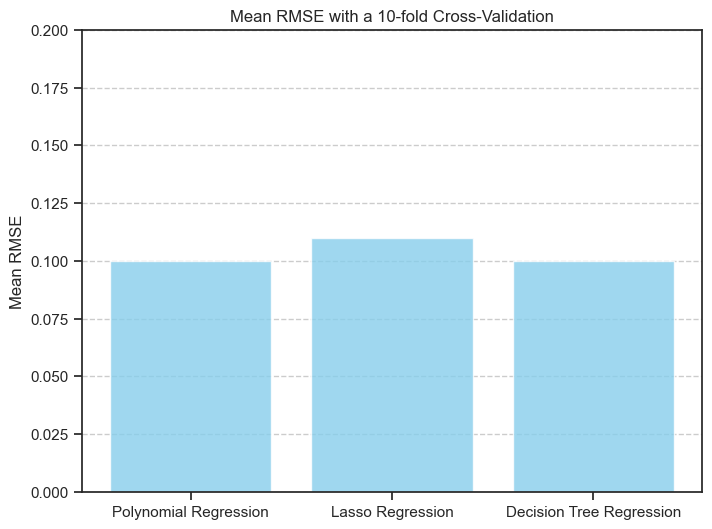

In [54]:
# Summarize the mean RMSE produced from each model

print(f'Mean RMSE of the Polynomial Model: {best_rmse_polynomial}\n'
      f'Mean RMSE of the Lasso Model: {best_rmse_lasso} \n'
      f'Mean RMSE of the Decision Tree Model: {best_rmse_tree_model} \n')

# Plot their RMSE for comparison
import matplotlib.pyplot as plt

models = ['Polynomial Regression', 'Lasso Regression', 
          'Decision Tree Regression'
          ]

mean_rmses = [best_rmse_polynomial, best_rmse_lasso, best_rmse_tree_model]

# Plot on a bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, mean_rmses, color='skyblue', alpha = 0.8)
plt.title('Mean RMSE with a 10-fold Cross-Validation')
plt.ylabel('Mean RMSE')
plt.ylim(0, 0.2)  # Set y-axis limit to show all bars clearly
plt.grid(axis='y', linestyle='--')
plt.show()

**7.1 Model Evaluation: Decision Tree Regression**

In [55]:
# Best Performing Model turn out to be both a second-degree
# Polynomial Regression and the Decision Tree Regression

# Let's double check the decision tree
optimized_tree_model = DecisionTreeRegressor(max_depth=4,
                                             max_features=9,
                                             min_samples_leaf=11,
                                             min_samples_split=2
                                             )

optimized_tree_model.fit(x_train, y_train)

y_pred = optimized_tree_model.predict(x_test)

# Calculate mean RMSE with a 10-fold cross-validation
cv_scores = cross_val_score(optimized_tree_model, x_train, y_train, cv=10, 
                            scoring='neg_mean_squared_error'
                            )
rmse_scores = np.sqrt(-cv_scores)
optimized_tree_mean_rmse = np.mean(rmse_scores)


print(f'RMSE (decision tree regression): {round(optimized_tree_mean_rmse,2)}')

RMSE (decision tree regression): 0.1


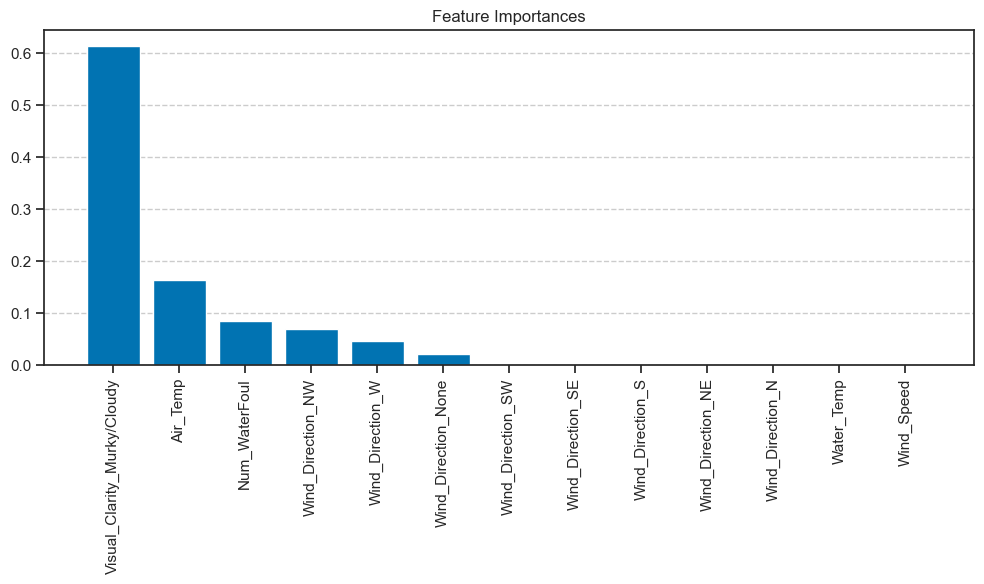

In [56]:
importances = optimized_tree_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(x_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
plt.tight_layout()
plt.grid(axis='y', linestyle='--')
plt.show()

**7.2: Model Evaluation: Polynomial Regression**

In [60]:
# Check the polynomial regression model
poly_features = PolynomialFeatures(degree=1) # simple linear function
x_train_poly = poly_features.fit_transform(x_train)

# Fit polynomial regression model
polynomial_model = LinearRegression().fit(x_train_poly, y_train)

# Predict y values using the model
x_test_poly = poly_features.fit_transform(x_test)
y_pred = polynomial_model.predict(x_test_poly)

# Calculate mean RMSE with a 10-fold cross-validation
cv_scores = cross_val_score(polynomial_model, x_train_poly, y_train, cv=10, 
                            scoring='neg_mean_squared_error'
                            )
rmse_scores = np.sqrt(-cv_scores)
poly_mean_rmse = np.mean(rmse_scores)

print(f'RMSE (polynomial regression): {round(poly_mean_rmse,2)}')

RMSE (polynomial regression): 0.1


Check the Data Distribution for Each Predictor Variable vs. Target Variable

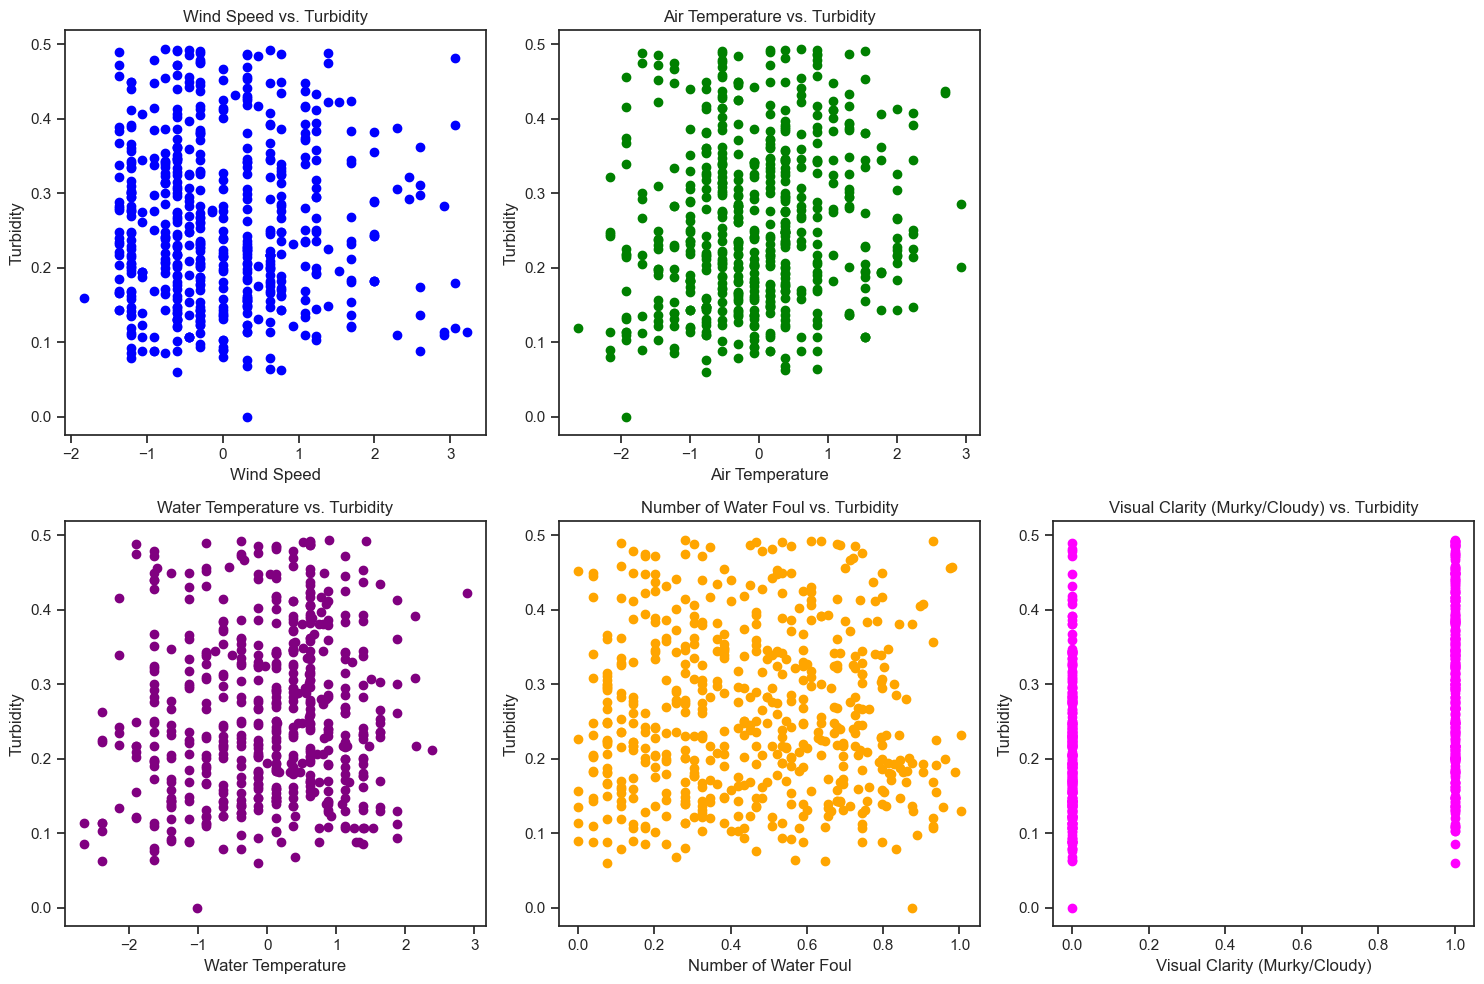

In [61]:
# Visually check if their relationships can be fitted by a quadratic function
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0, 0].scatter(x_train['Wind_Speed'], y_train, color='blue')
ax[0, 0].set_title('Wind Speed vs. Turbidity')
ax[0, 0].set_xlabel('Wind Speed')
ax[0, 0].set_ylabel('Turbidity')

ax[0, 1].scatter(x_train['Air_Temp'], y_train, color='green')
ax[0, 1].set_title('Air Temperature vs. Turbidity')
ax[0, 1].set_xlabel('Air Temperature')
ax[0, 1].set_ylabel('Turbidity')

ax[1, 0].scatter(x_train['Water_Temp'], y_train, color='purple')
ax[1, 0].set_title('Water Temperature vs. Turbidity')
ax[1, 0].set_xlabel('Water Temperature')
ax[1, 0].set_ylabel('Turbidity')

ax[1, 1].scatter(x_train['Num_WaterFoul'], y_train, color='orange')
ax[1, 1].set_title('Number of Water Foul vs. Turbidity')
ax[1, 1].set_xlabel('Number of Water Foul')
ax[1, 1].set_ylabel('Turbidity')

ax[1, 2].scatter(x_train['Visual_Clarity_Murky/Cloudy'], y_train, color='magenta')
ax[1, 2].set_title('Visual Clarity (Murky/Cloudy) vs. Turbidity')
ax[1, 2].set_xlabel('Visual Clarity (Murky/Cloudy)')
ax[1, 2].set_ylabel('Turbidity')

# It doesn't look like their relationship can be fitted by quadratic functions
ax[0, 2].axis('off')
plt.tight_layout()
plt.show()

**Check for Normality in Residuals using the "Shapiro-Wilk Normality Test"**

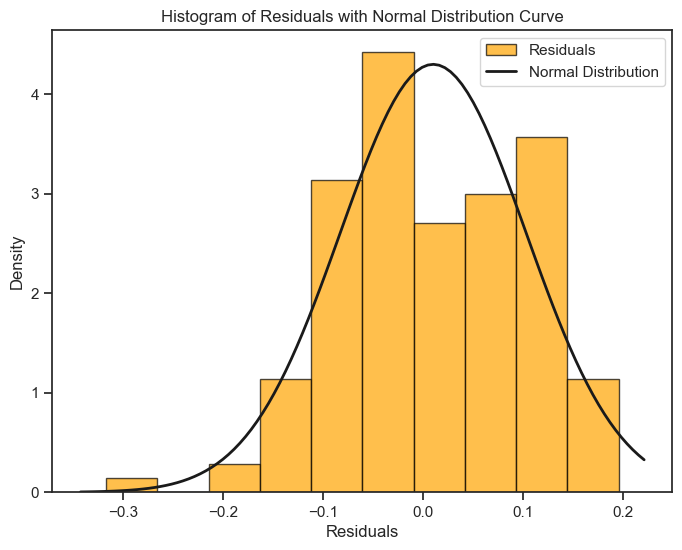

Shapiro-Wilk test statistic: 0.9782045750339597
p-value: 0.027123648775181787
Residuals are not normally distributed (reject null hypothesis)


In [62]:
from scipy.stats import norm
from scipy.stats import shapiro

# Calculate residuals
residuals = y_test - y_pred

# Plot histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=10, density=True, color='orange', edgecolor='black', alpha=0.7, label='Residuals')

# Overlay a normal distribution curve
mu, sigma = norm.fit(residuals)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')

plt.title('Histogram of Residuals with Normal Distribution Curve')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.show()

# Perform Shapiro-Wilk test for normality
statistic, p_value = shapiro(residuals)
print("Shapiro-Wilk test statistic:", statistic)
print("p-value:", p_value)

if p_value > 0.05:
    print("Residuals are approximately normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

**Check for Autocorrelation**

<Figure size 800x600 with 0 Axes>

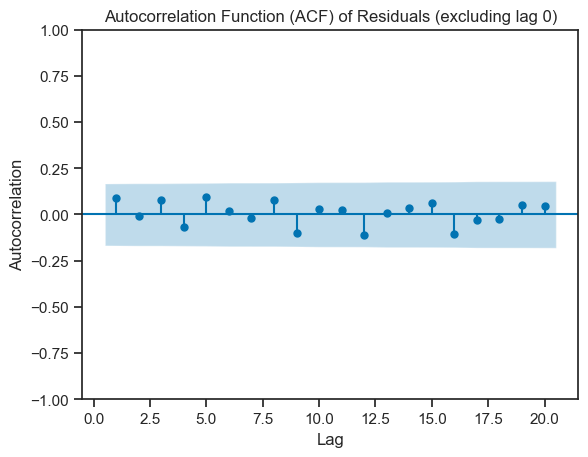

Durbin-Watson test statistic: 1.794586886139821
No significant autocorrelation detected.


In [63]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf

# Calculate Durbin-Watson test statistic
dw_statistic = durbin_watson(residuals)


# Plot autocorrelation function (ACF) of residuals
plt.figure(figsize=(8, 6))
plot_acf(residuals, lags=20, zero=False)  # Exclude lag 0 from the plot
plt.title('Autocorrelation Function (ACF) of Residuals (excluding lag 0)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Print test statistic
print("Durbin-Watson test statistic:", dw_statistic)

# Interpret the test statistic
if dw_statistic < 1.5:
    print("Positive autocorrelation detected.")
elif dw_statistic > 2.5:
    print("Negative autocorrelation detected.")
else:
    print("No significant autocorrelation detected.")

**Check for Heteroscedasticity**

In [64]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# Add constant column to the exogenous variables
exog = sm.add_constant(x_test)

# Perform Breusch-Pagan test for heteroscedasticity
bp_statistic, bp_p_value, _, _ = het_breuschpagan(residuals, exog)
print("Breusch-Pagan test statistic:", bp_statistic)
print("p-value:", bp_p_value)

if bp_p_value > 0.05:
    print("Residuals exhibit homoscedasticity (fail to reject null hypothesis)")
else:
    print("Residuals exhibit heteroscedasticity (reject null hypothesis)")

Breusch-Pagan test statistic: 11.837922165361006
p-value: 0.5409770187678262
Residuals exhibit homoscedasticity (fail to reject null hypothesis)
